---
# Tutorial Task: Sentiment-Based Quant Strategy
---

In this tutorial, you will design and implement a **quantitative trading strategy** that makes trading decisions based on **news sentiment** for a selected group of 5 stocks.

## Objective

Each day, over a 1-week historical period:
- **Buy** (go long) the stock with the **most positive** news sentiment
- **Sell** (go short) the stock with the **most negative** news sentiment

You will:
1. Select your own **universe of 3 stocks** (e.g., AAPL, DNUT, BRK-B).
2. Use the provided News API to retrieve articles for each stock.
3. Calculate the **average sentiment** for each stock daily using tools like `TextBlob`.
4. Track your portfolio’s value over time by simulating simple returns (real or mock).
5. Plot your portfolio value and analyze strategy performance.

## Constraints

- The News API is limited to **100 requests per day**. Avoid excessive API calls while developing by storing data or limiting requests.
- You only trade **one long and one short position** per day.
- Keep it simple: assume equal capital allocation to long and short trades.

## Deliverables

- A working Jupyter notebook implementing the above strategy
- Comments and clear structure for readability
- A final plot showing portfolio value over the 1-week period


## Step 1:
Import relevant libraries

In [1]:
# Data analysis
import pandas as pd
import numpy as np
# API calls
import requests
# Sentiment analysis
from textblob import TextBlob
# Time arithmetic
from datetime import datetime, timedelta
# Plotting
import matplotlib.pyplot as plt
# Financial data
import yfinance as yf

## Step 2:
Configure API

In [2]:
# Information to call API
API_KEY = 'INSERT-API-KEY'  # Replace with your actual key
BASE_URL = 'https://newsapi.org/v2/everything'

## Step 3:
Create a function to get news and calculate the sentiment

In [3]:
# We use TextBlob() to calculate sentiment - show students an example:

print(TextBlob("This stock is amazing!").sentiment.polarity)  # ➝ ~0.8 to 1.0 (positive)
print(TextBlob("This stock is okay.").sentiment.polarity)     # ➝ ~0.2 (slightly positive)
print(TextBlob("This stock is bad.").sentiment.polarity)      # ➝ ~-0.7 (negative)
print(TextBlob("This is a stock.").sentiment.polarity)    

0.7500000000000001
0.5
-0.6999999999999998
0.0


In [4]:
# We make a function to call the API and get the sentiment of a stock over a day
def get_sentiment(stock, date):
    from_date = date.strftime('%Y-%m-%d')
    to_date = (date + timedelta(days=1)).strftime('%Y-%m-%d')

    params = {
        'q': stock,
        'from': from_date,
        'to': to_date,
        'sortBy': 'relevancy',
        'apiKey': API_KEY,
        'language': 'en',
        'pageSize': 5
    }

    # Call API with the relevant stock and dates
    response = requests.get(BASE_URL, params=params)
    data = response.json() # response in a .json format
    
    print(data)

    sentiments = []
    for article in data.get('articles', []):
        title = article.get('title', '')
        description = article.get('description', '')
        
        if not title and not description:
            continue  # skip if both are missing
        
        text = f"{title} {description}"
        # Get sentiment of text
        sentiment = TextBlob(text).sentiment.polarity
        sentiments.append(sentiment)

    if sentiments:
        mean = np.mean(sentiments)
        print(mean)
        return mean # return the mean sentiment of the stock over the day
    return None

In [5]:
get_sentiment('AAPL', datetime(2025, 5, 5))

{'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}


## Step 4:
Simulate Backtesting

In [ ]:
def gather_daily_sentiments(stocks, start_date, end_date):
    """
    For each date in [start_date, end_date], calls get_sentiment(stock, date)
    and returns a DataFrame of shape (n_dates × n_stocks) of daily polarity.
    """
    dates = pd.date_range(start_date, end_date)
    # initialize an empty DataFrame
    sentiments = pd.DataFrame(index=dates, columns=stocks, dtype=float)

    for date in dates:
        for stock in stocks:
                sentiments.at[date, stock] = get_sentiment(stock, date)
    return sentiments


def fetch_price_data(stocks, start_date, end_date):
    """
    Downloads daily OHLC data for each ticker in `stocks` between start_date and end_date.
    Returns a dict mapping ticker → its DataFrame.
    """
    price_data = {}
    for stock in stocks:
        df = yf.download(
            stock,
            start=start_date.strftime('%Y-%m-%d'),
            end=(end_date + timedelta(days=1)).strftime('%Y-%m-%d'),
            interval='1d',
            progress=False
        )
        price_data[stock] = df[['Open', 'Close']]  # keep only what is needed
    return price_data

In [ ]:
# Define parameters for the API and functions
START_DATE = pd.to_datetime('2025-04-28')
END_DATE   = pd.to_datetime('2025-05-09')
STOCK_UNIVERSE = ['AAPL','DNUT','BRK-B']

# 1) get your sentiment surface
sentiment_df = gather_daily_sentiments(STOCK_UNIVERSE, START_DATE, END_DATE)

# 2) pull in all your price data
price_dict   = fetch_price_data(STOCK_UNIVERSE, START_DATE, END_DATE)

# now students will have have:
# - sentiment_df.loc[date, stock] → polarity of the stock on that date
# - price_dict[stock].loc[date, ['Open','Close']] → prices

{'status': 'ok', 'totalResults': 70, 'articles': [{'source': {'id': None, 'name': 'AppleInsider'}, 'author': 'news@appleinsider.com (Wesley Hilliard)', 'title': 'Consumers get ahead of tariffs, Morgan Stanley hikes AAPL price target to $235', 'description': "Morgan Stanley hiked its Apple stock price target to $235 because instability created by the Trump administration's tariffs may be a boon to Apple's bottom line — at least in the short term.iPhone 16 Pro Max could have seen a sale bump in early 2025Even after…", 'url': 'https://appleinsider.com/articles/25/04/28/consumers-get-ahead-of-tariffs-morgan-stanley-hikes-aapl-price-target-to-235', 'urlToImage': 'https://photos5.appleinsider.com/gallery/63435-131825-Cameras-16-Pro-Max-xl.jpg', 'publishedAt': '2025-04-28T20:47:49Z', 'content': "Morgan Stanley hiked its Apple stock price target to $235 because instability created by the Trump administration's tariffs may be a boon to Apple's bottom line — at least in the short term.\r\nEven a

In [ ]:
# Daily sentiment per stock
sentiment_df

,AAPL,DNUT,BRK-B
2025-04-28,-0.005000,0.200000,0.380952
2025-04-29,0.183333,NaN,0.523810
2025-04-30,0.002778,NaN,0.666667
2025-05-01,0.062778,NaN,0.211039
2025-05-02,0.108232,NaN,0.170000
2025-05-03,0.159820,NaN,0.153889
2025-05-04,0.128905,0.010000,0.114352
2025-05-05,0.023734,0.010000,0.051574
2025-05-06,0.300337,NaN,0.106111
2025-05-07,0.372143,0.113333,0.421429


In [ ]:
# Price for AAPL
print(price_dict['AAPL'])

Price             Open       Close
Ticker            AAPL        AAPL
Date                              
2025-04-28  210.000000  210.139999
2025-04-29  208.690002  211.210007
2025-04-30  209.300003  212.500000
2025-05-01  209.080002  213.320007
2025-05-02  206.089996  205.350006
2025-05-05  203.100006  198.889999
2025-05-06  198.210007  198.509995
2025-05-07  199.169998  196.250000
2025-05-08  197.720001  197.490005
2025-05-09  199.000000  198.529999


In [ ]:
# Price for DNUT
print(price_dict['DNUT'])

Price       Open Close
Ticker      DNUT  DNUT
Date                  
2025-04-28  4.29  4.19
2025-04-29  4.15  4.14
2025-04-30  4.06  4.10
2025-05-01  4.12  4.22
2025-05-02  4.22  4.31
2025-05-05  4.30  4.27
2025-05-06  4.29  4.36
2025-05-07  4.40  4.33
2025-05-08  3.03  3.26
2025-05-09  3.27  2.73


In [ ]:
# Price for BRK-B
print(price_dict['BRK-B'])

Price             Open       Close
Ticker           BRK-B       BRK-B
Date                              
2025-04-28  533.630005  530.940002
2025-04-29  531.000000  534.570007
2025-04-30  531.510010  533.250000
2025-05-01  531.000000  530.229980
2025-05-02  536.750000  539.799988
2025-05-05  520.080017  512.150024
2025-05-06  509.570007  512.330017
2025-05-07  515.020020  518.219971
2025-05-08  520.979980  513.250000
2025-05-09  514.250000  513.739990


In [ ]:
# Import backtesting functionality from python file (students will have this and to save time we will import it). We should run through it at a high level though.
from momentum_functions import backtest_sentiment_strategy

In [88]:
# Example usage:
results = backtest_sentiment_strategy(sentiment_df, price_dict, init_capital=100000)
results

/tmp/ipykernel_7392/2885429028.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(row['Open']), float(row['Close'])
/tmp/ipykernel_7392/2885429028.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(row['Open']), float(row['Close'])
/tmp/ipykernel_7392/2885429028.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(row['Open']), float(row['Close'])
/tmp/ipykernel_7392/2885429028.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(row['Open']), float(row['Close'])
/tmp/ipykernel_7392/2885429028.py:37: FutureWarning: Calling float on a single e

,long,short,open_long,close_long,open_short,close_short,pnl_long,pnl_short,daily_pnl,daily_return,portfolio_value
date,,,,,,,,,,,
2025-04-28,BRK-B,AAPL,533.630005,530.940002,210.000000,210.139999,-252.047525,-33.333188,-285.380713,-0.002854,99714.619287
2025-04-29,BRK-B,AAPL,531.000000,534.570007,208.690002,211.210007,335.199549,-602.044333,-266.844784,-0.002676,99447.774503
2025-04-30,BRK-B,AAPL,531.510010,533.250000,209.300003,212.500000,162.779772,-760.230698,-597.450926,-0.006008,98850.323577
2025-05-01,BRK-B,AAPL,531.000000,530.229980,209.080002,213.320007,-71.672957,-1002.309908,-1073.982865,-0.010865,97776.340712
2025-05-02,BRK-B,AAPL,536.750000,539.799988,206.089996,205.350006,277.798459,175.538693,453.337152,0.004636,98229.677864
2025-05-03,AAPL,BRK-B,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,98229.677864
2025-05-04,AAPL,DNUT,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,98229.677864
2025-05-05,BRK-B,DNUT,520.080017,512.150024,4.300000,4.270000,-748.885364,342.664048,-406.221316,-0.004135,97823.456548
2025-05-06,AAPL,BRK-B,198.210007,198.509995,509.570007,512.330017,74.027148,-264.923064,-190.895916,-0.001951,97632.560632


## Step 5:
Display results in ```matplotlib```

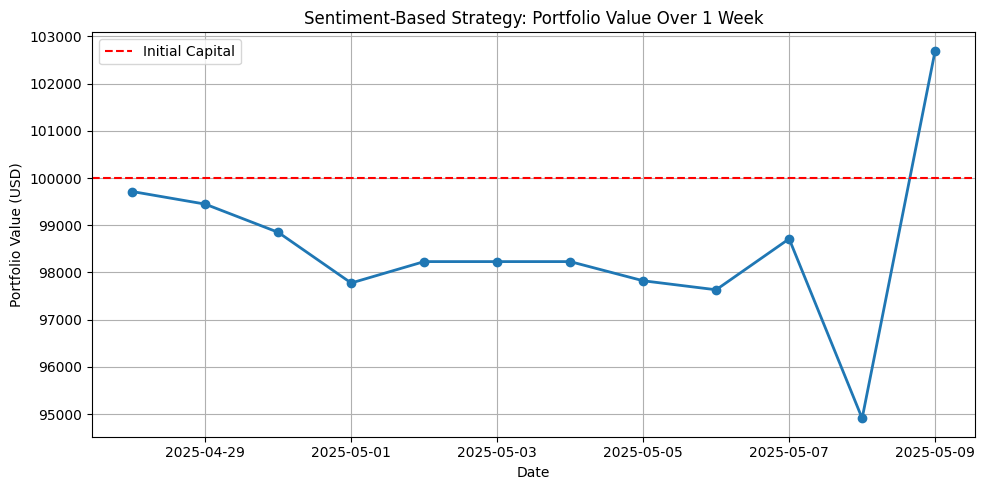

In [ ]:
# Plot the portfolio value
plt.figure(figsize=(10, 5))
plt.plot(results.index, results['portfolio_value'], marker='o', linewidth=2)
plt.title('Sentiment-Based Strategy: Portfolio Value Over 2 Weeks')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.axhline(y=100000, color='r', linestyle='--', label='Initial Capital')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()